# How to build a reliable, curated, and accurate RAG system using Cleanlab and Pinecone

Retrieval-Augmented Generation (RAG) is a powerful technique in natural language processing that combines the strengths of large language models with external knowledge retrieval. RAG systems enhance the capabilities of AI models by allowing them to access and utilize relevant information from a curated knowledge base, leading to more accurate, up-to-date, and context-aware responses. Building a reliable, curated, and accurate RAG system is crucial for several reasons:

- **Improved Accuracy:** By retrieving relevant information, RAG systems can provide more precise and factual responses.
- **Reduced Hallucinations:** Access to external knowledge helps minimize the risk of AI models generating false or inconsistent information.
- **Adaptability:** RAG systems can be easily updated with new information without retraining the entire model.
- **Trustworthiness:** The ability to trace responses back to source documents enhances explainability and trust in AI-generated content.

In this notebook, we'll explore how to build such a system using [Cleanlab](https://cleanlab.ai/) and Pinecone.
Cleanlab is a company that specializes in data-centric AI, focusing on improving the quality and reliability of AI/ML systems. Cleanlab's Trustworthy Language Model (TLM) is designed to add trust and reliability to AI model outputs and indicate when it's unsure of an answer, making it ideal for applications where unchecked hallucinations could be problematic. This is especially the case for anyone trying to build generative AI applications in production. 

Pinecone, as a vector database solution, excels in storing and retrieving high-dimensional vectors, making it perfect for managing and querying large-scale document embeddings.

By combining Cleanlab's TLM with Pinecone's vector database capabilities, we can create a RAG system that not only retrieves relevant information efficiently but also ensures the quality and reliability of the data being used. This notebook will guide you through the process of:

1. Using Cleanlab's TLM to tag and clean document data, removing low-quality chunks and personally identifiable information (PII).
2. Leveraging Pinecone to create and manage a vector database for storing and retrieving document embeddings.
3. Implementing a RAG pipeline that uses both tools to provide accurate and trustworthy responses.
4. Utilizing Cleanlab's TLM to classify metadata, enhance retrieval, and evaluate the trustworthiness of RAG outputs.

By the end of this notebook, you'll have a robust understanding of how to build a RAG system that prioritizes reliability, curation, and accuracy, setting a strong foundation for developing trustworthy AI applications.


![Reliable RAG with Pinecone and Cleanlab](cleanlab_pinecone_RAG.png)

In [78]:
%pip install -r requirements.txt

import pandas as pd
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import os
import pinecone
import uuid
from pinecone import ServerlessSpec
from sentence_transformers import SentenceTransformer
from typing import List, Tuple, Dict, Optional
from IPython import display
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)
display.clear_output()

In [2]:
if "PINECONE_API_KEY" not in os.environ:
    os.environ["PINECONE_API_KEY"] = input("Please enter your Pinecone API key: ")

Below is an example of how to set a Python index serverless specification, this allows us to define the cloud provider and region where we want to deploy our index. You can find a list of all [available providers and regions here](https://docs.pinecone.io/docs/projects).

In [3]:
cloud = os.environ.get("PINECONE_CLOUD") or "aws"
region = os.environ.get("PINECONE_REGION") or "us-east-1"

spec = ServerlessSpec(cloud=cloud, region=region)

## Load Documents Data

Let's read in our documents data that we will use in this workflow. The data columns include the `filename` of the document and the document `text`.

In [4]:
# Read in dataset
df = pd.read_csv("documents-RAG-demo.csv")
print(df.shape)

(103, 3)


In [5]:
df.head()

,index,filename,text
0,0,documents/Blackstone-Third-Quarter-2023-Invest...,Blackstone Third Quarter 2023 Investor Call Oc...
1,1,documents/8k-nike.pdf,SECURITIES AND EXCHANGE COMMISSIONFORM 8-K Cur...
2,2,documents/FY24-Q1-NIKE-Press-Release.pdf,NaN
3,3,documents/10-K 2022-Apple2.pdf,The future principal payments for the Company’...
4,4,documents/q3-fy22-earnings-presentation.pdf,Financial\tpresentation\tto\t accompany\tmanag...


## Analyze Documents Data

Let's look at how long our documents are and what the distribution of the text length looks like across the dataset.

Summary Statistics of Text Length:
count       103.000000
mean      11512.902913
std       20606.774397
min           0.000000
25%        1353.500000
50%        4382.000000
75%       10921.500000
max      143918.000000
Name: text_length, dtype: float64


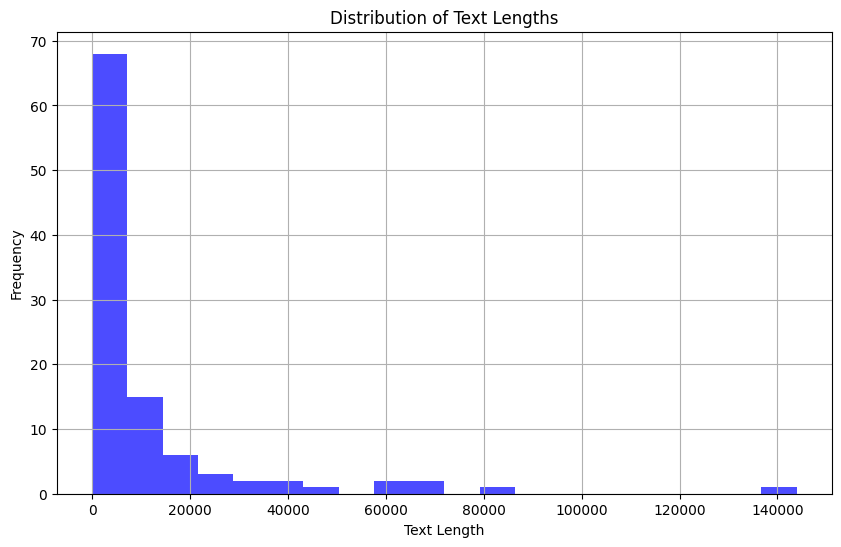

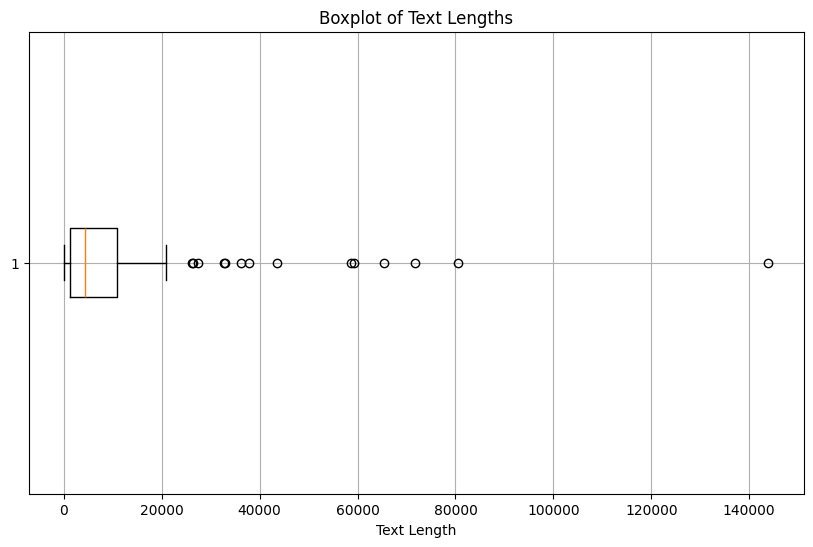

In [6]:
# Calculate the length of the text in the 'text' column
df["text_length"] = df["text"].apply(lambda x: len(x) if pd.notnull(x) else 0)

# Summary statistics
length_stats = df["text_length"].describe()
print("Summary Statistics of Text Length:")
print(length_stats)

# Plotting the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(df["text_length"], bins=20, color="blue", alpha=0.7)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plotting the distribution with outliers
plt.figure(figsize=(10, 6))
plt.boxplot(df["text_length"], vert=False)
plt.title("Boxplot of Text Lengths")
plt.xlabel("Text Length")
plt.grid(True)
plt.show()

## Use Cleanlab's TLM to tag your documents with a topic

Now that we have analyzed our documents data, we have a better idea of the length of the documents and the information we have available. For our RAG system, it would be ideal to tag each of our documents with a particular topic that is most relevant (based on the text content), which can be used as [metadata](https://docs.pinecone.io/guides/data/filter-with-metadata) we can filter with during retrieval in our RAG system. 

We can now use Cleanlab's [Trustworthy Language Model](https://cleanlab.ai/blog/trustworthy-language-model/) to tag our document chunks with the correct document topic that we can later use to enhance our retrieval process of fetching the correct context from our vector DB.

Cleanlab's Trustworthy Language Model (TLM) is a more reliable LLM that gives high-quality outputs and indicates when it is unsure of the answer to a question, making it suitable for applications where unchecked hallucinations are a show-stopper.

### Installing Cleanlab TLM

Using TLM requires a [Cleanlab](https://app.cleanlab.ai/) account. Sign up for one [here](https://cleanlab.ai/signup/) if you haven't yet. If you've already signed up, check your email for a personal login link.

Cleanlab's Python client can be installed using pip below (but the correct version used in this tutorial was installed in `requirements.txt` at the beginning of this notebook):

In [ ]:
%pip install cleanlab-studio

## Using the TLM

You can use the TLM pretty much like any other LLM API:

In [7]:
from cleanlab_studio import Studio

key = "YOUR API KEY HERE"

# Get API key from here: https://app.cleanlab.ai/account after creating an account.
studio = Studio(key)

# Use the most powerful OpenAI model with TLM
tlm = studio.TLM(quality_preset="high", options={"model": "gpt-4o"})

output = tlm.prompt("<your prompt>")

Let's now use Cleanlab's TLM under the hood by making use of the `enrich_data` function specified below from our [Python API](https://github.com/cleanlab/cleanlab-studio/blob/main/cleanlab_studio/utils/data_enrichment/enrich.py). We are passing the following arguments:

**Required Arguments:**

- `studio`, our Cleanlab Studio object we instantiated
- `data`, the DataFrame containing the original data we are enriching
- `prompt`, the prompt we want to use to enrich our data

**Optional Arguments:**
- `subset_indices`, what subset of the supplied data rows to generate metadata for. We set this to `None` which means we will run data enrichment on our full dataset for the given input prompt
- `new_column_name`, an optional name for the returned enriched column. Name acts as a prefix appended to all additional columns that are returned
- `**kwargs`, optional keywords arguments, including
  
    - `quality_preset`: we specify `quality_preset="high"` to improve our data enrichment responses at the expense of higher runtimes and higher token cost (the default quality is `medium`, see more details about the various presets [here](https://help.cleanlab.ai/reference/python/studio/\#method-tlm)).
    - `contrain_outputs`: If specified, every entry in the `metadata` column will exactly match one of these values. **Note**: If you specified the `constrain_outputs` argument, some additional transformations may be applied to raw LLM outputs to produce the returned values. In these cases, an additional `log` column will be added to the returned DataFrame that records the raw LLM outputs (feel free to disregard these). 

Now we can import our `enrich_data` function and define the prompt we will use to tag our documents with the correct topic.

In [8]:
from cleanlab_studio.utils.data_enrichment.enrich import enrich_data

In [9]:
## Use TLM for tagging
tagging_prompt = """
You are an assistant for tagging text as one of several topics. The available topics are:

1. 'finance': Related to financial matters, budgeting, accounting, investments, lending, or monetary policies.
2. 'hr': Pertaining to Human Resources, including hiring, employee documents (such as a W4 form), employee management, benefits, or workplace policies.
3. 'it': Covering Information Technology topics such as software development, network infrastructure, cybersecurity, or tech support.
4. 'product': Dealing with a specific company product, product development, management, features, or lifecycle.
5. 'sales': Involving selling a product, customer acquisition, revenue generation, or sales performance.

If you are not sure which topic to tag the text with, then answer 'unknown'.

Task: Analyze the following text and determine the topic it belongs to. Return the topic as a string.

Now here is the Text to verify:

Text: {text}

Topic: 
"""

In [10]:
%%time

topics_df = enrich_data(
    studio,
    df,
    tagging_prompt,
    subset_indices=None,
    new_column_name="topic",
    constrain_outputs=["finance", "hr", "it", "product", "sales", "unknown"],
    quality_preset="high",
    options={"model": "gpt-4o"},
)

Querying TLM... 100%|██████████|

CPU times: user 327 ms, sys: 124 ms, total: 451 ms
Wall time: 2.78 s


In [11]:
topics_df.head()

,topic,topic_trustworthiness,topic_log
0,finance,0.998507,finance
1,finance,0.998501,finance
2,unknown,0.999703,unknown
3,finance,0.997131,finance
4,finance,0.997237,finance


As seen above, after running `enrich_data`, you will notice three new columns in the dataset: 

- `topic`, a column with the response that we prompted for (after processing the response with any specified regex operations or constrained output operations)
- `topic_trustworthiness`, a corresponding trustworthiness score, which quantifies how confident you can be that the response is correct
- `topic_log`, if `regex` or specific outputs (via `constrain_outputs`) are specified, there will also be a log column which returns the raw response string from the LLM (before any other operations)

Note that the trustworthiness score corresponds to the original response string, and not to response that has been processed with any additional string handling.

We can also join the results with the original DataFrame below.

In [12]:
# Join the enriched topics DataFrame with the original DataFrame and drop the 'topic_log' column which is not needed.
enriched_topic_df = df.join(topics_df).drop(["topic_log", "text_length"], axis=1)
enriched_topic_df.head()

,index,filename,text,topic,topic_trustworthiness
0,0,documents/Blackstone-Third-Quarter-2023-Invest...,Blackstone Third Quarter 2023 Investor Call Oc...,finance,0.998507
1,1,documents/8k-nike.pdf,SECURITIES AND EXCHANGE COMMISSIONFORM 8-K Cur...,finance,0.998501
2,2,documents/FY24-Q1-NIKE-Press-Release.pdf,NaN,unknown,0.999703
3,3,documents/10-K 2022-Apple2.pdf,The future principal payments for the Company’...,finance,0.997131
4,4,documents/q3-fy22-earnings-presentation.pdf,Financial\tpresentation\tto\t accompany\tmanag...,finance,0.997237


Now we can use the [Trustworthiness Score](https://help.cleanlab.ai/tutorials/tlm/#how-does-the-tlm-trustworthiness-score-work) obtained in our results (as `topic_trustworthiness`) to analyze which of our topic responses are the most trustworthy and least trustworthy.

For our use case, at a low enough threshold score for `topic_trustworthiness`, we can replace the `topic` value for those responses with `unknown` since we can't be sure to trust those responses.

This threshold can be determined by sorting the results by the trustworthiness score and then looking for a cutoff point in the results when topic values seem unstrustworthy.

In practice, generally speaking, if you have the time/resources, your team can manually review low-trustworthiness responses and provide a better human response instead. If not, you can determine a trustworthiness threshold below which responses seem untrustworthy, and automatically append a warning statement to any response whose trustworthiness falls below the threshold or flag those responses in the appropriate way for your use case.

The overall magnitude/range of the trustworthiness scores may differ between datasets, so we recommend selecting any thresholds to be application-specific. First consider the relative trustworthiness levels between different data points before considering the overall magnitude of these scores for individual data points.

In [13]:
sorted_topic_df = enriched_topic_df.sort_values(
    by="topic_trustworthiness", ascending=False
).copy()
sorted_topic_df.head(10)

,index,filename,text,topic,topic_trustworthiness
81,81,documents/danby-3cuft-range.pdf,NaN,unknown,0.999703
2,2,documents/FY24-Q1-NIKE-Press-Release.pdf,NaN,unknown,0.999703
43,43,documents/Number_3.1_SEXUAL_HARASSMENT.pdf,NaN,unknown,0.999703
47,47,documents/Number_3.0_EQUAL_EMPLOYMENT_OPPORTUN...,NaN,unknown,0.999703
92,92,documents/sales-essentials.pptx,NaN,unknown,0.999703
25,25,documents/job-offer-worksheet-aug-2019.docx,NaN,unknown,0.999703
62,62,documents/Internet_and_Technology_Policy.docx,NaN,unknown,0.999703
85,85,documents/cognism-how-to-sell.pdf,NaN,unknown,0.999703
16,16,documents/Investor_Transcript_2023-10-26.pdf,REFINITIV STREETEVENTS EDITED TRANSCRIPT HTZ.O...,finance,0.999689
52,52,documents/Employment Eligibility Verification.pdf,bradtheexpert@gmail.com5143683509063103/04/197...,hr,0.999674


In [14]:
sorted_topic_df.tail(10)

,index,filename,text,topic,topic_trustworthiness
91,91,documents/best-buy-ask-for-sale.pdf,Selling Skills - SellAfter you have recommende...,sales,0.989628
73,73,documents/moen-single-handle-faucent.pdf,SpecificationsDESCRIPTION Reflex™ pulldown sys...,product,0.989325
61,61,documents/eligible-services.ppt,Eligible Services Service Provider TrainingS...,it,0.979110
82,82,documents/AMQ_Product_Spec-2024-01-24.docx,PRODUCTSModel #SpecificationsSELECTION\tQTY\tP...,product,0.793544
83,83,documents/frigidaire-window-unit.pdf,"15,100 BTU Connected Window-Mounted Room Air C...",product,0.770796
20,20,documents/UnreleasedGames.doc,EVERY GAME THAT WAS NEVER RELEASED FOR THE SPE...,unknown,0.762538
59,59,documents/internetsafety.ppt,Santa Rosa District SchoolsINTERNET SAFETYNove...,unknown,0.760741
8,8,documents/LD_Trucost_Company_Presentation_0504...,Quantitative Environmental Performance Measure...,product,0.723591
14,14,documents/RetailMailings.doc,Fidelity Investments FundsNetworkProcedures f...,finance,0.606362
58,58,documents/ElectricalRequestForm.pdf,Use this form to request parts and equipment f...,it,0.600412


After sorting the results in descending order by the `topic_trustworthiness` score, the results seem to be less trustworthy for scores less than 0.8.

Let's replace each of these less trustworthy`topic` responses with `unknown` now.

In [15]:
enriched_topic_df.loc[enriched_topic_df["topic_trustworthiness"] < 0.8, "topic"] = (
    "unknown"
)

To get a sense of the distribution of topics we've tagged in our documents data, let's plot the distribution now:


Topic Column Distribution:
topic
hr         30
finance    17
product    17
sales      16
unknown    15
it          8
Name: count, dtype: int64

Topic Percentage Distribution:
topic
hr         29.126214
finance    16.504854
product    16.504854
sales      15.533981
unknown    14.563107
it          7.766990
Name: proportion, dtype: float64


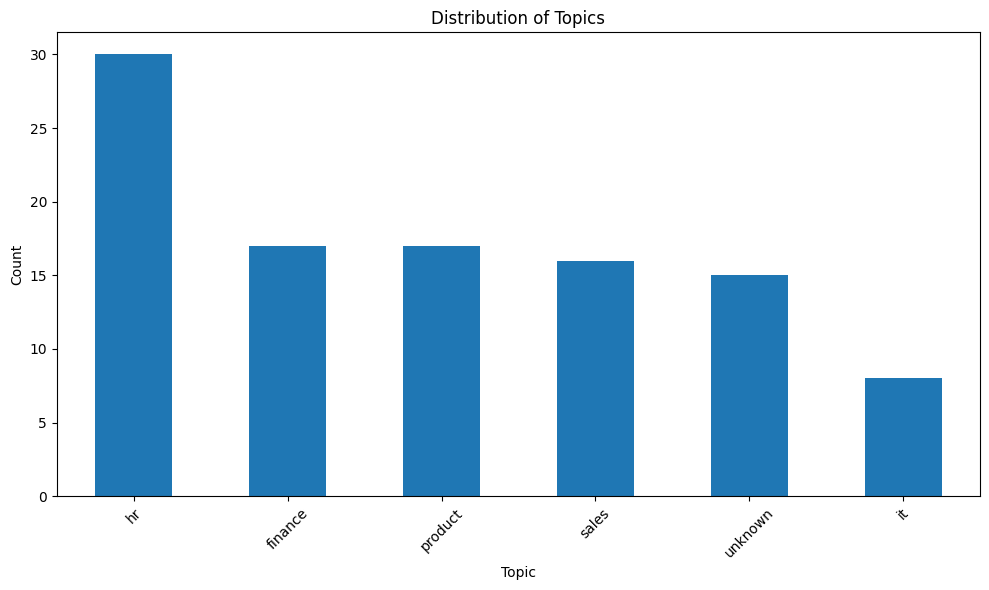

In [16]:
topic_counts = enriched_topic_df["topic"].value_counts(dropna=False)
print(f"\nTopic Column Distribution:\n{topic_counts}")

# Percentage distribution of topics
topic_percentages = enriched_topic_df["topic"].value_counts(normalize=True) * 100
print(f"\nTopic Percentage Distribution:\n{topic_percentages}")

# Visualize topic distribution
plt.figure(figsize=(10, 6))
topic_counts.plot(kind="bar")
plt.title("Distribution of Topics")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Initialize RAG Pipeline on initial documents data

In [17]:
import os
import uuid
from typing import List, Dict, Optional, Tuple

import pandas as pd
import pinecone
from sentence_transformers import SentenceTransformer

class PineconeRAGPipeline:
    def __init__(
        self,
        model_name: str = "paraphrase-MiniLM-L6-v2",
        index_name: str = "document-index",
        cloud: str = "aws",
        region: str = "us-east-1",
    ):
        """
        Initialize the PineconeRAGPipeline with a specified model and index name.

        Args:
            model_name (str): Name of the SentenceTransformer model to use.
            index_name (str): Name of the Pinecone index to create or connect to.
            cloud (str): Cloud provider for Pinecone.
            region (str): Region for the Pinecone service.
        """
        self.model = SentenceTransformer(model_name)
        if not os.environ.get("PINECONE_API_KEY"):
            os.environ["PINECONE_API_KEY"] = "YOUR PINECONE API KEY HERE"
        self.pc = pinecone.Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))
        self.index_name = index_name

        existing_indexes = self.pc.list_indexes()

        if self.index_name not in existing_indexes:
            try:
                print(f"Creating new index: {self.index_name}")
                self.pc.create_index(
                    name=self.index_name,
                    dimension=self.model.get_sentence_embedding_dimension(),
                    metric="cosine",
                    spec=pinecone.ServerlessSpec(cloud=cloud, region=region),
                )
            except Exception as e:
                if "ALREADY_EXISTS" in str(e):
                    print(
                        f"Index {self.index_name} already exists. Connecting to existing index."
                    )
                else:
                    raise e
        else:
            print(
                f"Index {self.index_name} already exists. Connecting to existing index."
            )

        self.index = self.pc.Index(self.index_name)

    def chunk_text(self, text: str, max_tokens: int = 256) -> List[str]:
        """
        Split text into chunks based on a maximum token size.

        Args:
            text (str): The document text to be chunked.
            max_tokens (int): The maximum number of tokens per chunk.

        Returns:
            List[str]: List of text chunks.
        """
        words = text.split()
        chunks = []
        current_chunk = []
        current_chunk_tokens = 0

        for word in words:
            word_tokens = len(self.model.tokenize([word])["input_ids"][0])
            if current_chunk_tokens + word_tokens > max_tokens and current_chunk:
                chunks.append(" ".join(current_chunk))
                current_chunk = []
                current_chunk_tokens = 0

            current_chunk.append(word)
            current_chunk_tokens += word_tokens

        if current_chunk:
            chunks.append(" ".join(current_chunk))

        for i, chunk in enumerate(chunks):
            print(
                f"Chunk {i+1} length: {len(chunk)} characters, "
                f"{len(self.model.tokenize([chunk])['input_ids'][0])} tokens"
            )

        return chunks

    def index_documents(self, df: pd.DataFrame) -> int:
        """
        Index documents from a DataFrame with specific metadata structure.

        Args:
            df (pd.DataFrame): DataFrame containing document information and metadata.
                               Expected columns: 'text', 'filename', 'topic'

        Returns:
            int: The number of chunks successfully indexed.
        """
        valid_docs = []
        valid_metadata = []
        generated_ids = []

        print("Starting document processing...")

        for idx, row in df.iterrows():
            if pd.isna(row["text"]) or pd.isna(row["filename"]) or pd.isna(row["topic"]):
                print(f"Skipping invalid document at index {idx}: {row['filename']}")
                continue

            doc = str(row["text"])
            print(f"Processing document {row['filename']} at index {idx}...")

            chunks = self.chunk_text(doc)

            for i, chunk in enumerate(chunks):
                chunk_id = str(uuid.uuid4())
                chunk_metadata = {
                    "filename": row["filename"],
                    "topic": row["topic"],
                    "chunk_index": i,
                    "total_chunks": len(chunks),
                    "chunk_id": chunk_id,
                }
                valid_docs.append(chunk)
                valid_metadata.append(chunk_metadata)
                generated_ids.append(chunk_id)

        print(f"Total chunks to encode: {len(valid_docs)}")

        if not valid_docs:
            print("No valid documents to index.")
            return 0

        doc_embeddings = self.model.encode(valid_docs)

        batch_size = 100
        for i in range(0, len(valid_docs), batch_size):
            batch_docs = valid_docs[i : i + batch_size]
            batch_metadata = valid_metadata[i : i + batch_size]
            batch_embeddings = doc_embeddings[i : i + batch_size]

            vectors = [
                (
                    generated_ids[i + j],
                    embedding.tolist(),
                    {**metadata, "text": doc[:1000]},
                )
                for j, (doc, embedding, metadata) in enumerate(
                    zip(batch_docs, batch_embeddings, batch_metadata)
                )
            ]

            try:
                self.index.upsert(vectors=vectors)
                print(f"Successfully indexed batch of {len(vectors)} chunks.")
            except Exception as e:
                print(f"Error during upsert: {e}")

        print("Document indexing completed.")
        return len(valid_docs)

    def search(
        self, query: str, top_k: int = 5, filter_query: Optional[Dict] = None
    ) -> List[Tuple[str, Dict]]:
        """
        Search for the top_k most relevant documents based on the input query and optional filter.

        Args:
            query (str): The search query text.
            top_k (int): The number of top relevant documents to return.
            filter_query (Optional[Dict]): Optional filter query to apply during search.

        Returns:
            List[Tuple[str, Dict]]: List of top_k relevant document texts and their metadata.
                                    Each tuple contains (document_text, metadata_dict).
        """
        query_embedding = self.model.encode(query)

        try:
            results = self.index.query(
                vector=query_embedding.tolist(),
                top_k=top_k,
                filter=filter_query,
                include_metadata=True,
            )

            return [
                (
                    match.metadata["text"],
                    {k: v for k, v in match.metadata.items() if k != "text"},
                )
                for match in results.matches
            ]
        except Exception as e:
            print(f"Error during search: {e}")
            return []

    def delete_index(self) -> None:
        """
        Delete the Pinecone index.

        Raises:
            Exception: If there's an error during the deletion process.
        """
        try:
            self.pc.delete_index(self.index_name)
            print(f"Index '{self.index_name}' has been deleted.")
        except Exception as e:
            print(f"Error deleting index: {e}")

    def extract_all_chunks_from_index(self, max_chunks: int = 10000) -> pd.DataFrame:
        """
        Extract all document chunks and metadata from the Pinecone index into a DataFrame.

        Args:
            max_chunks (int): Maximum number of chunks to retrieve.

        Returns:
            pd.DataFrame: DataFrame containing chunk data and metadata.
                          Columns include all metadata fields stored in the index.

        Raises:
            Exception: If there's an error retrieving chunks from the index.
        """
        stats = self.index.describe_index_stats()
        total_vectors = stats.total_vector_count
        dimension = stats.dimension

        print(f"Index name: {self.index_name}")
        print(f"Total vectors according to stats: {total_vectors}")
        print(f"Vector dimension: {dimension}")

        try:
            results = self.index.query(
                vector=[0.0] * dimension,
                top_k=max_chunks,
                include_values=False,
                include_metadata=True,
            )

            chunk_data = [match.metadata for match in results.matches]
            chunk_df = pd.DataFrame(chunk_data)

            print(f"Total chunks retrieved: {len(chunk_df)}")
            return chunk_df

        except Exception as e:
            print(f"Error retrieving chunks from index: {e}")
            return pd.DataFrame()

    def delete_chunks(self, chunk_ids: List[str]) -> None:
        """
        Delete specific chunks from the Pinecone index.

        Args:
            chunk_ids (List[str]): List of chunk IDs to delete.

        Raises:
            Exception: If there's an error during the deletion process.
        """
        try:
            self.index.delete(ids=chunk_ids)
            print(f"Successfully deleted {len(chunk_ids)} chunks from the index.")
        except Exception as e:
            print(f"Error deleting chunks: {e}")
            print(f"Problematic chunk IDs: {chunk_ids}")

        print(f"Finished deletion process for {len(chunk_ids)} chunks.")

Let's use the RAG pipeline we have defined above to create a Pinecone index - then we upsert our document chunks into our vector DB in batches.

In [18]:
# Intialize RAG pipeline on unfiltered documents
rag_pipeline = PineconeRAGPipeline(index_name="cleanlab-pinecone-index")
rag_pipeline.index_documents(enriched_topic_df)

Creating new index: cleanlab-pinecone-index
Starting document processing...
Processing document documents/Blackstone-Third-Quarter-2023-Investor-Call.pdf at index 0...
Chunk 1 length: 465 characters, 106 tokens
Chunk 2 length: 492 characters, 102 tokens
Chunk 3 length: 462 characters, 98 tokens
Chunk 4 length: 464 characters, 108 tokens
Chunk 5 length: 428 characters, 106 tokens
Chunk 6 length: 465 characters, 94 tokens
Chunk 7 length: 551 characters, 110 tokens
Chunk 8 length: 509 characters, 100 tokens
Chunk 9 length: 449 characters, 99 tokens
Chunk 10 length: 499 characters, 98 tokens
Chunk 11 length: 515 characters, 96 tokens
Chunk 12 length: 531 characters, 106 tokens
Chunk 13 length: 520 characters, 104 tokens
Chunk 14 length: 570 characters, 102 tokens
Chunk 15 length: 498 characters, 100 tokens
Chunk 16 length: 483 characters, 100 tokens
Chunk 17 length: 485 characters, 104 tokens
Chunk 18 length: 532 characters, 97 tokens
Chunk 19 length: 541 characters, 99 tokens
Chunk 20 len

2432

After upserting our document chunks, let's now confirm that the upsertion worked properly (after waiting 30 seconds to give the vector DB time to update) by reading the document chunks into a new DataFrame `chunk_df`.

In [19]:
time.sleep(30)

# Extract chunks from the Pinecone index into a DataFrame
chunk_df = rag_pipeline.extract_all_chunks_from_index()

# Display the resulting DataFrame
chunk_df.head()

Index name: cleanlab-pinecone-index
Total vectors according to stats: 3832
Vector dimension: 384
Total chunks retrieved: 2432


,chunk_id,chunk_index,filename,text,topic,total_chunks
0,665aa22e-d7e2-4fb7-8d68-642fc16d4075,4.0,documents/Walmart_2022_Investor_Information.pdf,follows:2023HighLow1st Quarter(1)$146.94$132.0...,finance,9.0
1,6e31f706-9c51-4a42-9f05-7f30732c1d5d,5.0,documents/2012_14.doc,Pay transactions on HUE01 using the following ...,hr,17.0
2,3af3f7e6-df1f-4d39-9cd5-9d8d00555b45,5.0,documents/internet_safety.pptx,"751-5980 (800) 487-1626 (8 a.m. to 5 p.m. CST,...",it,6.0
3,13ff91dc-993b-4d2c-a1df-9f79ce5ad4b6,139.0,documents/Investor_Transcript_2023-10-26.pdf,"PROVIDE AN ACCURATE TRANSCRIPTION, THERE MAY B...",finance,141.0
4,8455df48-6b3a-48ea-bd43-870637ec4a15,12.0,documents/2012_14.doc,When entering deduction override amounts for a...,hr,17.0


In [20]:
chunk_df.shape

(2432, 6)

In [21]:
document_data_columns = list(chunk_df.columns)
print(f"The columns in our documents data are: {document_data_columns}")

The columns in our documents data are: ['chunk_id', 'chunk_index', 'filename', 'text', 'topic', 'total_chunks']


We can see below that the number of chunks per document varies:

In [22]:
chunks_per_doc = chunk_df.groupby("filename")["chunk_index"].max() + 1
print(chunks_per_doc)

filename
documents/10-K 2022-Apple.pdf                                               3.0
documents/10-K 2022-Apple2.pdf                                             16.0
documents/2012_14.doc                                                      17.0
documents/2020_-_I-9_Employment_Verification_Training_Presentation.ppt     17.0
documents/2023-CEASampleEmployeeHandbook.doc                              286.0
                                                                          ...  
documents/the-selling-process-1.pdf                                         7.0
documents/the-selling-process-2.pdf                                        10.0
documents/unit04.pdf                                                       22.0
documents/what-is-selling.pptx                                              7.0
documents/work-ez-specs.pdf                                                 2.0
Name: chunk_index, Length: 95, dtype: float64


## Use Cleanlab's TLM to detect and filter out bad document chunks

Now that we have extracted our document chunks from our Pinecone index, let's use Cleanlab's TLM (via our `enrich_data` function we previously used) to detect low quality document chunks (i.e. HTML, not interpretable/cut off phrases, or non English text) and personally identifiable information (PII) to filter out these chunks from our vector DB.

Below we define the prompts we will use to find the document chunks that are badly chunked or contain PII.

In [23]:
%%time

bad_chunks_prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 

Task: Analyze the following text and determine if it's badly chunked. A badly chunked text can contain HTML, have text or phrases that are hard to understand, or be non english text. 

Return 'bad_chunk' if it's badly chunked, and 'good_chunk' if it's not. Please be as accurate as possible, the world depends on it.

Text: {text}
"""

bad_chunks_df = enrich_data(
    studio,
    chunk_df,
    bad_chunks_prompt,
    subset_indices=None,
    new_column_name="chunk_quality",
    constrain_outputs=["bad_chunk", "good_chunk"],
    quality_preset="high",
    options={"model": "gpt-4o"},
)

Querying TLM... 100%|██████████|

CPU times: user 2min 9s, sys: 26.8 s, total: 2min 36s
Wall time: 4min 54s


In [24]:
%%time

pii_prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 

Task: Analyze the following text and determine if it has personally identifiable information (PII). PII is information that could be used to identify an individual or is otherwise sensitive. Names, addresses, phone numbers are examples of common PII.

Return 'is_PII' if the text contains PII and 'no_PII' if it does not. Please be as accurate as possible, the world depends on it.

Text: {text}
"""

pii_df = enrich_data(
    studio,
    chunk_df,
    pii_prompt,
    subset_indices=None,
    new_column_name="pii_check",
    constrain_outputs=["is_PII", "no_PII"],
    quality_preset="high",
    options={"model": "gpt-4o"},
)

Querying TLM... 100%|██████████|

CPU times: user 1min 57s, sys: 23.7 s, total: 2min 21s
Wall time: 9min 20s


In [25]:
# Join the enriched chunks and pii DataFrames with the original chunks DataFrame and drop the 'chunk_quality_log' and 'pii_check_log' columns which are not needed.
enriched_chunks_df = (
    chunk_df.join(bad_chunks_df)
    .join(pii_df)
    .drop(["chunk_quality_log", "pii_check_log"], axis=1)
)

enriched_chunks_df.head()

,chunk_id,chunk_index,filename,text,topic,total_chunks,chunk_quality,chunk_quality_trustworthiness,pii_check,pii_check_trustworthiness
0,665aa22e-d7e2-4fb7-8d68-642fc16d4075,4.0,documents/Walmart_2022_Investor_Information.pdf,follows:2023HighLow1st Quarter(1)$146.94$132.0...,finance,9.0,bad_chunk,0.737538,no_PII,0.995806
1,6e31f706-9c51-4a42-9f05-7f30732c1d5d,5.0,documents/2012_14.doc,Pay transactions on HUE01 using the following ...,hr,17.0,good_chunk,0.991026,no_PII,0.993511
2,3af3f7e6-df1f-4d39-9cd5-9d8d00555b45,5.0,documents/internet_safety.pptx,"751-5980 (800) 487-1626 (8 a.m. to 5 p.m. CST,...",it,6.0,bad_chunk,0.185356,is_PII,0.996854
3,13ff91dc-993b-4d2c-a1df-9f79ce5ad4b6,139.0,documents/Investor_Transcript_2023-10-26.pdf,"PROVIDE AN ACCURATE TRANSCRIPTION, THERE MAY B...",finance,141.0,good_chunk,0.822372,no_PII,0.994769
4,8455df48-6b3a-48ea-bd43-870637ec4a15,12.0,documents/2012_14.doc,When entering deduction override amounts for a...,hr,17.0,good_chunk,0.541582,no_PII,0.994747


In [26]:
sorted_chunk_quality_df = enriched_chunks_df.sort_values(
    by="chunk_quality_trustworthiness", ascending=False
).copy()
sorted_is_pii_df = enriched_chunks_df.sort_values(
    by="pii_check_trustworthiness", ascending=False
).copy()

Now let's check how many document chunks are bad chunks or contain PII but also in which the response trustworthiness score is >= 0.95, which represent the most trustworthy responses using TLM. 

In [27]:
worst_chunks = sorted_chunk_quality_df.query(
    "chunk_quality == 'bad_chunk' and chunk_quality_trustworthiness >= 0.95"
)
worst_pii = sorted_is_pii_df.query(
    "pii_check == 'is_PII' and pii_check_trustworthiness >= 0.95"
)

print(
    f"Number of document chunks that have the worst chunk quality based on trustworthiness: {worst_chunks.shape[0]}"
)
print(
    f"Number of document chunks have the worst PII based on trustworthiness: {worst_pii.shape[0]}"
)

Number of document chunks that have the worst chunk quality based on trustworthiness: 543
Number of document chunks have the worst PII based on trustworthiness: 94


We have observed the capabilities that Cleanlab's TLM can provide in detecting these low quality document chunks, so let's now:

1. Update our Pinecone DB by removing the chunks with any of the issues detected by Cleanlab
2. Verify that the update to our Pinecone DB worked

Let's observe some of the worst chunks that we are going to delete:

In [28]:
print(worst_chunks["text"][388])
print("-" * 500)
print(worst_chunks["text"][1443])

"terseLabel": "Trading Symbol"} }, "localname": "TradingSymbol", "nsuri": "http://xbrl.sec.gov/dei/2021", "presentation": ["http://www.nike.com/role/CoverPageCoverPage"], "xbrltype": "tradingSymbolItemType"}, "dei_WrittenCommunications": {"auth_ref": ["r6"], "lang": {"en-us": { "role": {"documentation": "Boolean flag that is true when the Form 8-K filing is intended to satisfy the filing obligation of the registrant as written communications pursuant
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
}, "localname": "EntityCentralIndexKey", "ns

These chunks are clearly not easy to understand nor do they represent full English phrases.

Now let's observe some of the worst examples of PII that we are going to delete:

In [29]:
print(worst_pii["text"][84])
print("-" * 500)
print(worst_pii["text"][2153])

an effective department onboarding experience, please refer to the Manager’s Checklist on page four.Happy onboarding! Keep in mind that assistance is available throughout this process. We want a positive onboarding experience for both you and your new employee. Please contact Talent Development at 713-221-8060 or td@uhd.edu for assistance.3Manager’s Checklist for Onboarding New EmployeesInitialNew
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
via the FundsNetwork.com web site. If you don’t have a password to enter the web site, please cont

These examples contain sensitive information such as phone numbers, email addresses and personal names that are flagged by Cleanlab - so these definitely contain PII that can be removed!

We can now construct the list of chunks to delete based on the `chunk_id` we previously created for each chunk that we can tie to each chunk in our vector DB.

In [30]:
# Get the chunk IDs for the chunks that have issues to update our Pinecone index
worst_chunks_to_delete_ids = worst_chunks["chunk_id"].tolist()
worst_pii_to_delete_ids = worst_pii["chunk_id"].tolist()
chunks_to_delete_ids = list(set(worst_chunks_to_delete_ids + worst_pii_to_delete_ids))

In [31]:
len(chunks_to_delete_ids)

613

In [32]:
# Delete the identified chunks from the index
rag_pipeline.delete_chunks(chunks_to_delete_ids)

Successfully deleted 613 chunks from the index.
Finished deletion process for 613 chunks.


After deleting our document chunks, let's now confirm that the deletion worked properly (after waiting 30 seconds to give the vector DB time to update) by reading the document chunks into a new DataFrame `updated_chunk_df`.

We will also then confirm the number of chunks deleted is equal to the total number of original chunks minus the number of chunks after filtering out bad chunks.

In [33]:
# Sleep timer to allow the deletion process to complete
time.sleep(30)

# Verify the update went through and we have the correct number of chunks
updated_chunk_df = rag_pipeline.extract_all_chunks_from_index()
updated_chunk_df.head()

Index name: cleanlab-pinecone-index
Total vectors according to stats: 1819
Vector dimension: 384
Total chunks retrieved: 1819


,chunk_id,chunk_index,filename,text,topic,total_chunks
0,ef6a24eb-8f1c-41a2-a2c7-8769fe264022,17.0,documents/product-instructions-oven.docx,`STOP' button or re-started by pressing the `S...,product,61.0
1,16d5705a-f4c9-4d9d-885e-548c3057c8fc,18.0,documents/product-instructions-oven.docx,THE TIMER WILL NOT SWITCH THE OVEN ON!General ...,product,61.0
2,7853f92a-e0a4-4283-b8ce-b4eb8f29caaa,19.0,documents/product-instructions-oven.docx,'LESS' buttons while cooking is in progress te...,product,61.0
3,d1ca3947-1ed0-4765-8f04-bca67886b99b,20.0,documents/product-instructions-oven.docx,button. Pressing ‘START’ will continue the coo...,product,61.0
4,5a8369f8-1392-49f7-a1b2-2817e11e2c9a,21.0,documents/product-instructions-oven.docx,"normal, including weight and time if required,...",product,61.0


In [34]:
# Confirm the number of chunks deleted is equal to the total number of original chunks minus the number of chunks after filtering out bad chunks
assert len(chunk_df) - len(updated_chunk_df) == len(chunks_to_delete_ids)

**Note:** You can also run this data ingestion (tagging, chunking, and cleaning) into a Pinecone vector DB index in real-time as new documents are being ingested. 

### How to search for documents with metadata

Below is an example on how you can search for your curated documents based on a query of your choice and use metadata to help filter for the relevant information. 

In this case, we specify `topic = sales` to find the `top k` (where k is number of results to return and equal to 2 here) documents that best match the search query/metadata filters.

In [35]:
results = rag_pipeline.search(
    query="Tell me about sales",  # YOUR SEARCH QUERY HERE
    top_k=2,
    filter_query={"topic": {"$eq": "sales"}},
)

for doc_text, metadata in results:
    print(f"Document: {doc_text[:100]}...")
    print(f"Metadata: {metadata}")
    print("---")

Document: learn the person’s name, position, age, education, experience, hobbies, etc. Many times, just gettin...
Metadata: {'chunk_id': 'f8a5c10a-93bf-4cff-84b9-735ac6dcd65e', 'chunk_index': 5.0, 'filename': 'documents/the-selling-process-2.pdf', 'topic': 'sales', 'total_chunks': 10.0}
---
Document: often used in a streamlined sales process.You have completed the topic for the sales process. Thank ...
Metadata: {'chunk_id': 'bc6ea237-27c7-42f6-93dd-957a85f077e2', 'chunk_index': 14.0, 'filename': 'documents/sap-sales-overview.pdf', 'topic': 'sales', 'total_chunks': 15.0}
---


## Use Cleanlab's TLM to classify metadata

Suppose our application asks this user which topic their question is about from a pre-defined list. Alternatively, we could train a classifier to predict the topic from the question (automatically using Cleanlab's TLM).

In [36]:
def classify_question_topic(question: str, tlm) -> str:
    """
    Classifies a given question into one of several predefined topics using a language model.

    This function takes a question and a Transformative Language Model (TLM) object,
    constructs a prompt to classify the question into one of several topics
    (finance, hr, it, product, sales, or unknown), and returns the classified topic.

    Args:
        question (str): The question to be classified.
        tlm: An object representing the Trustworthy Language Model

    Returns:
        str: The classified topic as determined by the language model.
             Possible values are 'finance', 'hr', 'it', 'product', 'sales', or 'unknown'.
    """
    classfying_metadata_prompt = f"""
    You are an assistant for classifying a question as one of several topics. The available topics are:

    1. 'finance': Related to financial matters, budgeting, accounting, investments, lending, or monetary policies.
    2. 'hr': Pertaining to Human Resources, including hiring, employee documents (such as a W4 form), employee management, benefits, or workplace policies.
    3. 'it': Covering Information Technology topics such as software development, network infrastructure, cybersecurity, or tech support.
    4. 'product': Dealing with a specific company product, product development, management, features, or lifecycle.
    5. 'sales': Involving selling a product, customer acquisition, revenue generation, or sales performance.

    If you are not sure which topic to classify the question as, then answer 'unknown'.

    Task: Analyze the following question and determine the topic it belongs to. Return the topic only.

    Now here is the question to verify:

    Question: {question}

    Topic: 
    """

    metadata_topic_response = tlm.prompt(classfying_metadata_prompt)
    return metadata_topic_response

In [37]:
question = "What were Blackstone's fee-related earnings in the third quarter of 2023?"

Using the question and prompt defined above, let's now use TLM to classify the question into the correct topic that we will use as the metadata to filter our vector DB query with:

In [38]:
metadata_topic_response = classify_question_topic(question, tlm)
print(metadata_topic_response)

# Extract the topic from the response
metadata_topic = metadata_topic_response["response"]

{'response': 'finance', 'trustworthiness_score': 0.9995227576664483}


Below, you can then specify the classified metadata topic (or other relevant metadata) when filtering to help search for the relevant context in your Pinecone index.

In [39]:
# Use the classified topic to filter the search results
top_doc_chunk = rag_pipeline.search(
    question, top_k=1, filter_query={"topic": {"$eq": metadata_topic}}
)
print(f"Top document chunk for this query: \n\n{top_doc_chunk[0][0]}")

Top document chunk for this query: 

of year-over-year base management fee growth at Blackstone. Fee-related earnings were $1.1 billion in the third quarter, or $0.92 per share, largely stable with Q2, underpinned by steady top-line performance, along with the firm's strong margin position. The year-over-year comparison was affected by a decline in transaction fees, which are activity-based, as well as lower fee-related performance revenues. Notwithstanding these headwinds, the firm generated $275 million of fee-related performance revenues in


## Use Cleanlab's TLM to get Trustworthiness Score for RAG Outputs

Now let's use the context from our top document chunk we obtained in the previous step to actually answer the original question asked: `What were Blackstone's fee-related earnings in the third quarter of 2023?`

In [40]:
top_doc_chunks = "".join(
    rag_pipeline.search(
        question, top_k=1, filter_query={"topic": {"$eq": metadata_topic}}
    )[0][0]
)

prompt = f"""You are an assistant for answering the following question based on the document context.

Question: {question}
Document Context: {top_doc_chunks}
"""

Now let's query TLM using the prompt we previously created using our user query + document context passed from our RAG Pinecone index.

In [41]:
output = tlm.prompt(prompt)
output

{'response': "Blackstone's fee-related earnings in the third quarter of 2023 were $1.1 billion.",
 'trustworthiness_score': 0.993302111747707}

### Is this response correct?

In [69]:
text_to_check = updated_chunk_df.query("filename == 'documents/Blackstone-Third-Quarter-2023-Investor-Call.pdf'").reset_index(drop=True).iloc[34]["text"]

# We can see our answer is correct below
text_to_check[60:119]

'Fee-related earnings were $1.1 billion in the third quarter'

### Can we find a hallucination?

Let's now try to find a hallucination but first classify this new question into the correct metadata topic value.

In [43]:
question = "For the potato chips product, what is the 4th smallest box dimension?"

In [44]:
metadata_topic_response = classify_question_topic(question, tlm)
print(metadata_topic_response)

# Extract the topic from the response
metadata_topic = metadata_topic_response["response"]

{'response': 'product', 'trustworthiness_score': 0.9927732973305581}


In [45]:
top_doc_chunks = "".join(
    rag_pipeline.search(
        question, top_k=1, filter_query={"topic": {"$eq": metadata_topic}}
    )[0][0]
)

prompt = f"""You are an assistant for answering the following question based on the document context.

Question: {question}
Document Context: {top_doc_chunks}
"""

# Runs the Cleanlab TLM with confidence reliablity scores on a different model with default quality preset
tlm = studio.TLM(options={"model": "gpt-3.5-turbo-16k"})

output = tlm.prompt(prompt)
output

{'response': 'The 4th smallest box dimension for the potato chips product is the height, which is 8 3/8 inches.',
 'trustworthiness_score': 0.5592042899944127}

### Is this correct?

In [70]:
# We can see there are only 3 numbers (dimensions) not 4
text_to_check = updated_chunk_df.query("filename == 'documents/potato-chips-specs.pdf'").iloc[0]["text"]
text_to_check[164:199]

'Box L x W x H: 15 7/16 X 13 X 8 3/8'

### Apply Cleanlab's TLM to Existing RAG Prompt/Response Pairs

We can also make use of the [get_trustworthiness_score](https://help.cleanlab.ai/reference/python/trustworthy_language_model/#method-get_trustworthiness_score) function from Cleanlab's TLM Python API to generate a trustworthiness score for prompt/response pairs that you already have. This can be relevant for a RAG system in which you already have retrieved the context and obtained a response from your LLM but still want to add trust and reliability to these input/output pairs.

In [71]:
# Redefine TLM to use the high quality preset and GPT-4o model
tlm = studio.TLM(quality_preset="high", options={"model": "gpt-4o"})

prompt = """Based on the following documents, answer the given question. 

Documents:  We're getting new desks! Specs are here: Staples Model RTG120XLDBL BasePage \
CollectionModel | Dimensions width = 60.0in height = 48.0in depth = 24.0in Base Color Black \
Top Color White | Specs SheetsPowered by TCPDF (www.tcpdf.org)

Question: What is the width of the new desks?
"""

response_A = "60 inches"
response_B = "24 inches"

trust_score_A = tlm.get_trustworthiness_score(prompt, response_A)
trust_score_B = tlm.get_trustworthiness_score(prompt, response_B)

print(f"TLM Score for Response A: {trust_score_A}")
print(f"TLM Score for Response B: {trust_score_B}")

TLM Score for Response A: 0.8209634111514514
TLM Score for Response B: 0.09573812948850895


The trustworthiness score for the prompt/response pair that has the correct response is expectedly much higher (and therefore more trustworthy) than the prompt/response pair with the incorrect response.

To summarize, we used Cleanlab and Pinecone to build a reliable, curated, and accurate RAG system.

We used Pinecone to create the DB to actually store our document data and help us create accurate metadata to label our documents/chunks. We used Pinecone to create the vector database, actually store our chunks of document data/metadata, and as our similarity search engine - which all play a crucial part in the storage/retrieval components of RAG. 

We used Cleanlab's Trustworthy Language Model (TLM) to first tag our document chunks and then ensure no badly chunked data or PII exists in the vector DB in order to curate more accurate and reliable documents. This ensures that, during retrieval from the RAG system, only the most relevant subset of  documents is considered. Lastly, we used TLM to classify metadata for use in retrieval and used TLM to show how to get trustworthiness scores for RAG Outputs to eliminate hallucinations and nonsensical answers.

For more guidance on how you can leverage TLM in RAG applications, you can refer to this Cleanlab Python API [tutorial](https://help.cleanlab.ai/tutorials/tlm_rag/).